In [36]:
import numpy as np
import torch
from sklearn.decomposition import PCA
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import torch.nn.functional as F

# Function to load preprocessed CIFAR-10 data
def load_preprocessed_cifar10_data():
    train_data_path = 'D:\\ASU\\Fall 2024\\EEE549\\Final term project\\sml-final\\data\\preprocessed\\cifar10\\preprocessed_train_cifar.pt'
    test_data_path = 'D:\\ASU\\Fall 2024\\EEE549\\Final term project\\sml-final\\data\\preprocessed\\cifar10\\preprocessed_test_cifar.pt'

    train_data, train_targets = torch.load(train_data_path, weights_only=False)
    test_data, test_targets = torch.load(test_data_path, weights_only=False)

    X_train = train_data.reshape(train_data.shape[0], -1)
    X_test = test_data.reshape(test_data.shape[0], -1)
    y_train = train_targets.numpy()
    y_test = test_targets.numpy()

    return X_train, X_test, y_train, y_test

# Load and preprocess data
X_train, X_test, y_train, y_test = load_preprocessed_cifar10_data()

In [15]:
# Splitting data for validation (optional)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(8000, 3072)
(2000, 3072)
(8000,)
(2000,)


In [16]:
# Apply PCA to reduce dimensions
pca = PCA(n_components=150)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)  # Transform validation set
X_test_pca = pca.transform(X_test)

# Convert PCA data back to tensors for training
X_train_pca_tensor = torch.tensor(X_train_pca, dtype=torch.float)
X_val_pca_tensor = torch.tensor(X_val_pca, dtype=torch.float)
X_test_pca_tensor = torch.tensor(X_test_pca, dtype=torch.float)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

In [17]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(150, 64)  # 150 features from PCA
        self.fc2 = nn.Linear(64, 10)   # Output 10 classes

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Create the neural network
model = SimpleNN()

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# DataLoader setup
train_dataset = TensorDataset(X_train_pca_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_pca_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_pca_tensor, y_test_tensor)

trainloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valloader = DataLoader(val_dataset, batch_size=64, shuffle=False)
testloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Function to calculate accuracy
def calculate_accuracy(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in data_loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

# Train the model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    train_acc = calculate_accuracy(model, trainloader)
    val_acc = calculate_accuracy(model, valloader)
    test_acc = calculate_accuracy(model, testloader)
    train_error = running_loss / len(trainloader)
    test_error = criterion(model(X_test_pca_tensor), y_test_tensor).item()

    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_error:.4f}, Test Loss: {test_error:.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%, Test Acc: {test_acc:.2f}%')

Epoch 1/100, Train Loss: 11.6455, Test Loss: 4.4935, Train Acc: 75.03%, Val Acc: 69.70%, Test Acc: 71.40%
Epoch 2/100, Train Loss: 2.9918, Test Loss: 2.7961, Train Acc: 79.30%, Val Acc: 72.45%, Test Acc: 72.55%
Epoch 3/100, Train Loss: 1.5443, Test Loss: 2.1164, Train Acc: 79.46%, Val Acc: 71.70%, Test Acc: 73.00%
Epoch 4/100, Train Loss: 0.9397, Test Loss: 1.4937, Train Acc: 83.30%, Val Acc: 72.40%, Test Acc: 72.55%
Epoch 5/100, Train Loss: 0.6587, Test Loss: 1.2784, Train Acc: 83.42%, Val Acc: 71.20%, Test Acc: 72.55%
Epoch 6/100, Train Loss: 0.4949, Test Loss: 1.0243, Train Acc: 86.10%, Val Acc: 72.80%, Test Acc: 74.35%
Epoch 7/100, Train Loss: 0.4054, Test Loss: 0.8864, Train Acc: 88.66%, Val Acc: 75.15%, Test Acc: 75.10%
Epoch 8/100, Train Loss: 0.3499, Test Loss: 0.8960, Train Acc: 89.05%, Val Acc: 73.75%, Test Acc: 75.05%
Epoch 9/100, Train Loss: 0.3785, Test Loss: 0.9023, Train Acc: 89.42%, Val Acc: 74.75%, Test Acc: 75.50%
Epoch 10/100, Train Loss: 0.3077, Test Loss: 0.8896, T

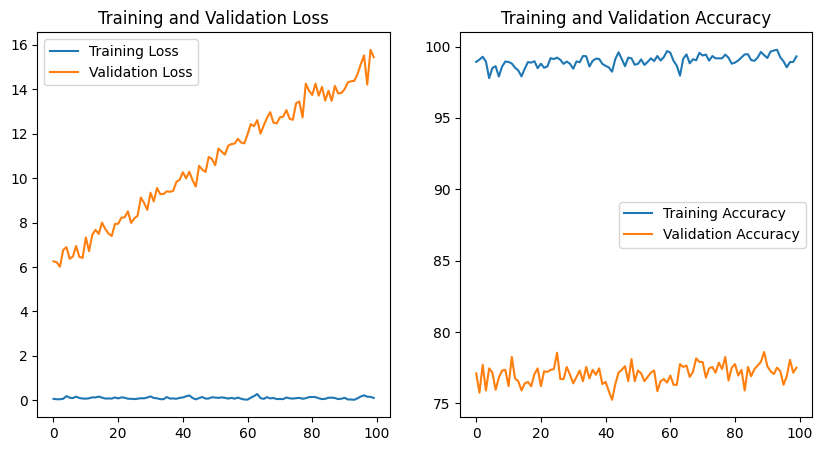

In [32]:
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for data in trainloader:
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_losses.append(train_loss / len(trainloader))
    train_accuracies.append(100 * correct / total)

    # Validation phase
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in valloader:
            inputs, labels = data
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_losses.append(val_loss / len(valloader))
    val_accuracies.append(100 * correct / total)

# Plot training and validation losses
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training and validation accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


Explained Variance Ratio: [2.62377493e-01 1.20793883e-01 6.66600879e-02 3.45674315e-02
 3.10868796e-02 2.83579118e-02 2.53442276e-02 2.40228937e-02
 1.79898671e-02 1.52534467e-02 1.35763411e-02 1.27506688e-02
 1.12118463e-02 1.05154509e-02 9.83467701e-03 9.74916112e-03
 9.46733390e-03 8.02762481e-03 7.56342497e-03 7.18025000e-03
 6.45017172e-03 6.25615005e-03 5.85864135e-03 5.50382077e-03
 4.95919960e-03 4.78210139e-03 4.53090139e-03 4.29633033e-03
 4.21865716e-03 3.94088366e-03 3.87618169e-03 3.63769428e-03
 3.59150320e-03 3.40315903e-03 3.25372564e-03 3.19862724e-03
 2.98291264e-03 2.85369858e-03 2.80716123e-03 2.70993444e-03
 2.63902298e-03 2.48275932e-03 2.44613942e-03 2.33403294e-03
 2.28354574e-03 2.22125096e-03 2.15132038e-03 2.10629496e-03
 2.04134585e-03 1.98733497e-03 1.91951394e-03 1.87779674e-03
 1.81949264e-03 1.79065312e-03 1.77579981e-03 1.70623887e-03
 1.66104884e-03 1.62061714e-03 1.58076586e-03 1.55698791e-03
 1.55001784e-03 1.53425257e-03 1.50989650e-03 1.48712773e-0

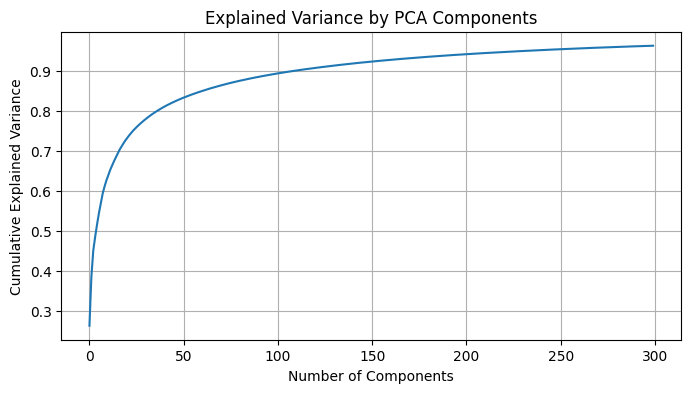

In [19]:
# Apply PCA to reduce dimensions
pca = PCA(n_components=300)  # Assuming you want to see the variance explained by more components
X_train_pca = pca.fit_transform(X_train)
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

# Plot cumulative explained variance
plt.figure(figsize=(8, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.grid(True)
plt.show()


In [ ]:
# Final evaluation on test set
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.numpy())
        all_labels.extend(labels.numpy())

# Convert lists to arrays for metric calculations
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)


              precision    recall  f1-score   support

        Deer       0.77      0.79      0.78      1000
       Horse       0.78      0.77      0.77      1000

    accuracy                           0.78      2000
   macro avg       0.78      0.78      0.78      2000
weighted avg       0.78      0.78      0.78      2000



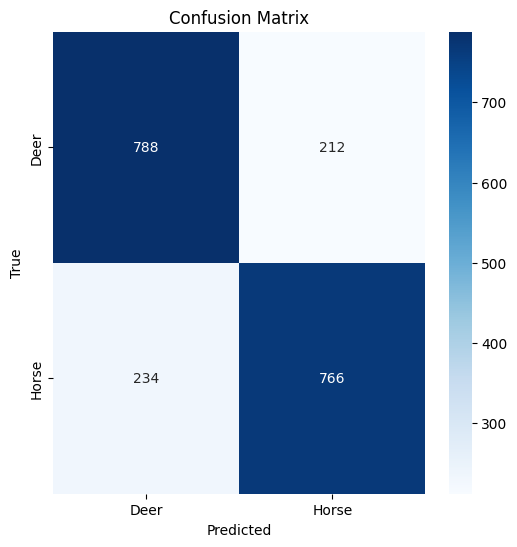

In [26]:
# Print classification report
print(classification_report(all_labels, all_preds, target_names=['Deer', 'Horse']))

# Plot confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Deer', 'Horse'], yticklabels=['Deer', 'Horse'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [28]:
model.eval()  # Set the model to evaluation mode
pred_prob = []  # Initialize an empty list to store probabilities

with torch.no_grad():  # Turn off gradients, as they are not needed for evaluation
    for images, _ in testloader:  # Assume testloader is already defined and correct
        outputs = model(images)  # Get model outputs
        probabilities = torch.softmax(outputs, dim=1)  # Apply softmax to convert outputs to probabilities
        pred_prob.append(probabilities.cpu().numpy())  # Collect probabilities, move to CPU if necessary

# Concatenate all collected probabilities into a single numpy array
pred_prob = np.concatenate(pred_prob, axis=0)

# Now you can extract probabilities for the positive class (assuming Horse is the second class, index 1)
horse_probs = pred_prob[:, 1]

In [29]:
from sklearn.metrics import roc_auc_score
auroc_score = roc_auc_score(all_labels, horse_probs)
print(f'AUROC for Horse vs. Deer: {auroc_score:.2f}')

AUROC for Horse vs. Deer: 0.85


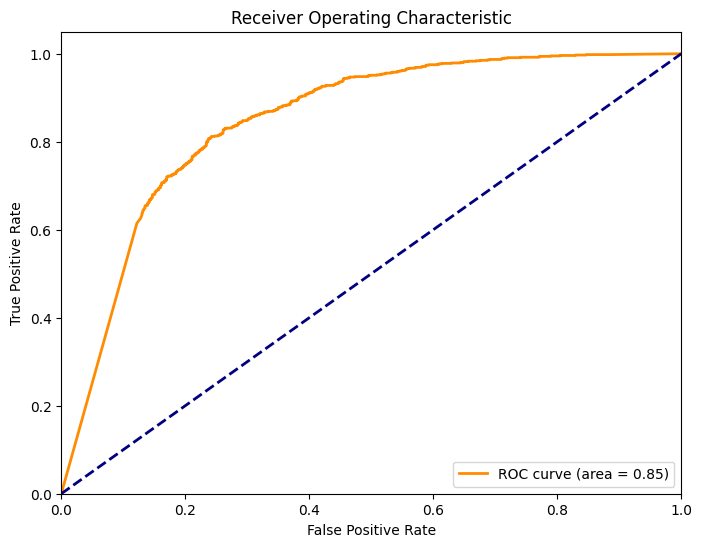

In [31]:
model.eval()  # Set the model to evaluation mode
pred_prob = []  # Initialize an empty list to store probabilities

with torch.no_grad():  # Turn off gradients
    for images, _ in testloader:  # Load batches of test data
        outputs = model(images)
        probabilities = torch.softmax(outputs, dim=1)
        pred_prob.append(probabilities.cpu().numpy())

pred_prob = np.concatenate(pred_prob, axis=0)
horse_probs = pred_prob[:, 1]  #

fpr, tpr, thresholds = roc_curve(all_labels, horse_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

PCA Components: 10, Train Accuracy: 73.17, Test Accuracy: 73.2
PCA Components: 50, Train Accuracy: 84.53, Test Accuracy: 78.4
PCA Components: 100, Train Accuracy: 89.17, Test Accuracy: 81.05
PCA Components: 200, Train Accuracy: 95.5, Test Accuracy: 82.5
PCA Components: 784, Train Accuracy: 99.95, Test Accuracy: 80.1


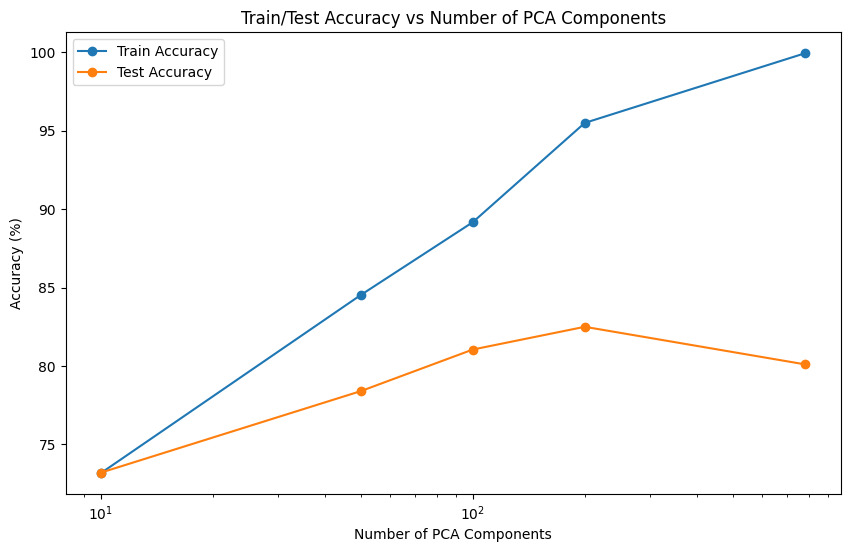

In [37]:
# Define a simple neural network architecture
class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 50)
        self.fc2 = nn.Linear(50, 10)  # Assuming a 10-class classification problem

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Number of PCA components to test
components = [10, 50, 100, 200, 784]  # Adjust 784 to your actual input size if different
train_accuracies = []
test_accuracies = []

for n_components in components:
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)
    
    # Convert numpy arrays to PyTorch datasets
    train_dataset = TensorDataset(torch.FloatTensor(X_train_pca), torch.LongTensor(y_train))
    test_dataset = TensorDataset(torch.FloatTensor(X_test_pca), torch.LongTensor(y_test))
    
    trainloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    testloader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    
    # Initialize the network
    model = SimpleNN(input_size=n_components)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training the model
    model.train()
    for epoch in range(10):  # Smaller number of epochs for demonstration
        for data, target in trainloader:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

    # Evaluating training accuracy
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for data, target in trainloader:
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    train_accuracy = 100 * correct / total
    train_accuracies.append(train_accuracy)

    # Evaluating testing accuracy
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in testloader:
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    test_accuracy = 100 * correct / total
    test_accuracies.append(test_accuracy)

    print(f'PCA Components: {n_components}, Train Accuracy: {train_accuracy}, Test Accuracy: {test_accuracy}')

# Plotting results
plt.figure(figsize=(10, 6))
plt.plot(components, train_accuracies, marker='o', label='Train Accuracy')
plt.plot(components, test_accuracies, marker='o', label='Test Accuracy')
plt.xlabel('Number of PCA Components')
plt.ylabel('Accuracy (%)')
plt.title('Train/Test Accuracy vs Number of PCA Components')
plt.xscale('log')  # Optional, if the component range is broad
plt.legend()
plt.show()